# EDA Ofertas Relámpago Mercado Libre
## Junio a Julio 2021

En este documento se mostrara un análisis descriptivo de las ofertas relámpago en mercado libre para un país determinado. Del 1 de junio al 31 de julio de 2021. Para esto primero se realizará una configuración inicial del presente documento. Luego se realizará una estandarización de la información de entrada y unos ejercicios de ingeniría de características que se creen pueden ser importantes. Después, se pasará a realizar un análisis descriptivo de todas las ofertas, donde se tomarán las cantidades vendidas como la variable objetivo de cara a la necesidad del negocio. Por último, en consonancia con leer el comportamiento de las cantidades vendidas, se analizará de forma descriptiva la serie de tiempo de las ventas diarias.

### 1. Configuración Inicial

Se procede a instalar las librerías con su versión correspondiente, instalarlas y tomar la configuración de visualización para no tener problemas en la ejecución del presente notebook:

In [1]:
# Importar Librerías
import warnings
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
import itertools
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [2]:
# Configuraciones
warnings.filterwarnings('ignore')
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
%matplotlib inline

### 2. Lectura y Estandarización de la Información

Se realiza la lectura del dataset y se revisan los tipos de datos para corregir los que no correspondan:

In [3]:
# Lectura de Datos
data = pd.read_csv('Data/ofertas_relampago.csv')
# Tipos de dato
data_types = data.dtypes
pd.DataFrame(data_types)

,0
OFFER_START_DATE,object
OFFER_START_DTTM,object
OFFER_FINISH_DTTM,object
OFFER_TYPE,object
INVOLVED_STOCK,int64
REMAINING_STOCK_AFTER_END,int64
SOLD_AMOUNT,float64
SOLD_QUANTITY,float64
ORIGIN,object
SHIPPING_PAYMENT_TYPE,object


Se observa que el dataset tiene 13 variables de las cuales se utilizan las siguientes definiciones:

1. **OFFER_START_DATE**: Fecha de inicio de la oferta.
2. **OFFER_START_DTTM**: Fecha y hora exacta de inicio de la oferta.
3. **OFFER_FINISH_DTTM**: Fecha y hora exacta de finalización de la oferta.
4. **OFFER_TYPE**: Tipo de oferta, en este caso todas son ofertas relámpago "lightning_deal".
5. **INVOLVED_STOCK**: Stock involucrado en la oferta.
6. **REMAINING_STOCK_AFTER_END**: Stock restante después del fin de la oferta.
7. **SOLD_AMOUNT**: Valor de las ventas.
8. **SOLD_QUANTITY**: Cantidad de unidades vendidas.
9. **ORIGIN**: Tipo de oferta si es de Mercado Libre o de un Tercero.
10. **SHIPPING_PAYMENT_TYPE**: Tipo de pago del envío.
11. **DOM_DOMAIN_AGG1**: Dominio agregado 1.
12. **VERTICAL**: Vertical del producto.
13. **DOMAIN_ID**: ID del dominio (específico).

También las variables tipo fecha están en tipo object por lo que se modifican. Las demás están correctas:

In [4]:
# Convertir variables al tipo de dato necesario
data['OFFER_START_DATE'] = pd.to_datetime(data['OFFER_START_DATE'])
data['OFFER_START_DTTM'] = pd.to_datetime(data['OFFER_START_DTTM'])
data['OFFER_FINISH_DTTM'] = pd.to_datetime(data['OFFER_FINISH_DTTM'])

Se revisan clientes con valores nulos:

In [5]:
# Missin values por columna
missing_values = data.isnull().mean()
pd.DataFrame(missing_values)

,0
OFFER_START_DATE,0.000000
OFFER_START_DTTM,0.000000
OFFER_FINISH_DTTM,0.000000
OFFER_TYPE,0.000000
INVOLVED_STOCK,0.000000
REMAINING_STOCK_AFTER_END,0.000000
SOLD_AMOUNT,0.495774
SOLD_QUANTITY,0.495774
ORIGIN,0.767858
SHIPPING_PAYMENT_TYPE,0.000000


Debido a la naturaleza de las variables se imputan los valores de 0 a las cantidades y valores de venta. Para el origen se imputa el valor "B" como marcación de ofertas de terceros. Por último, para la variable de tipo de pago del envío se cambia el texto "none" por "paid_by_customer":

In [6]:
# Imputar los valores de venta nulos
data['SOLD_AMOUNT'].fillna(0, inplace=True)
data['SOLD_QUANTITY'].fillna(0, inplace=True)
data['ORIGIN'].fillna('B', inplace=True)
data['SHIPPING_PAYMENT_TYPE'].replace('none', 'paid_by_customer', inplace=True)

Por último, se quitan los registros duplicados quedandonos con **47.820** ofertas:

In [7]:
# Quitar filas duplicadas
print(data.shape)
data = data.drop_duplicates()
print(data.shape)

(48746, 13)
(47820, 13)


Se generan las variables de hora de inicio de la oferta y el tiempo de la oferta intuyendo el relacionamiento con las ventas:

In [8]:
data['START_HOUR'] = data['OFFER_START_DTTM'].dt.hour
data['OFFER_DURATION_HH'] = (data['OFFER_FINISH_DTTM'] - data['OFFER_START_DTTM']).apply(lambda x: math.floor(x.seconds / 3600))

In [9]:
# Vista del dataset final
data.head()

,OFFER_START_DATE,OFFER_START_DTTM,OFFER_FINISH_DTTM,OFFER_TYPE,INVOLVED_STOCK,REMAINING_STOCK_AFTER_END,SOLD_AMOUNT,SOLD_QUANTITY,ORIGIN,SHIPPING_PAYMENT_TYPE,DOM_DOMAIN_AGG1,VERTICAL,DOMAIN_ID,START_HOUR,OFFER_DURATION_HH
0,2021-06-22,2021-06-22 16:00:00+00:00,2021-06-22 23:02:43+00:00,lightning_deal,4,-2,4.72,6.0,A,paid_by_customer,PETS FOOD,CPG,MLM-BIRD_FOODS,16,7
1,2021-06-22,2021-06-22 13:00:00+00:00,2021-06-22 19:00:02+00:00,lightning_deal,5,5,0.00,0.0,B,free_shipping,PET PRODUCTS,OTHERS,MLM-ANIMAL_AND_PET_PRODUCTS,13,6
2,2021-06-22,2021-06-22 07:00:00+00:00,2021-06-22 13:00:01+00:00,lightning_deal,15,12,10.73,3.0,B,paid_by_customer,COMPUTERS,CE,MLM-SPEAKERS,7,6
3,2021-06-22,2021-06-22 19:00:00+00:00,2021-06-23 01:36:12+00:00,lightning_deal,15,13,7.03,2.0,B,paid_by_customer,COMPUTERS,CE,MLM-HEADPHONES,19,6
4,2021-06-22,2021-06-22 13:00:00+00:00,2021-06-22 15:48:12+00:00,lightning_deal,15,0,39.65,15.0,B,paid_by_customer,COMPUTERS,CE,MLM-HEADPHONES,13,2


### 3. EDA nivel de Ofertas

Para el análisis a nivel de ofertas cargadas se revisan primero las variables cuantitativas y posteriormente las variables categóricas:

#### Cuantitativas

In [10]:
all_numerical_columns = data.select_dtypes(include=['int64', 'int32', 'float64']).columns

In [11]:
numerical_summary = data[all_numerical_columns].describe()
skewness = data[all_numerical_columns].skew()
kurtosis = data[all_numerical_columns].kurtosis()
combined_stats = pd.concat([numerical_summary, pd.DataFrame(skewness, columns=['skewness']).T, pd.DataFrame(kurtosis, columns=['kurtosis']).T], axis=0)

combined_stats

,INVOLVED_STOCK,REMAINING_STOCK_AFTER_END,SOLD_AMOUNT,SOLD_QUANTITY,START_HOUR,OFFER_DURATION_HH
count,47820.000000,47820.000000,47820.000000,47820.000000,47820.000000,47820.000000
mean,35.153095,30.641029,26.271502,5.575638,13.181305,5.646466
std,208.339376,197.270692,128.189295,33.050404,4.517248,2.095930
min,1.000000,-192.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,4.000000,0.000000,0.000000,7.000000,6.000000
50%,10.000000,8.000000,1.490000,1.000000,13.000000,6.000000
75%,15.000000,15.000000,12.840000,3.000000,19.000000,6.000000
max,9000.000000,8635.000000,4836.570000,1646.000000,23.000000,15.000000
skewness,19.554826,19.910892,14.627197,17.925841,-0.084610,-1.515728
kurtosis,502.417617,512.808912,323.446720,506.349778,-1.231148,2.388142


Se puede observar inicialmente que todo las ofertas deben manifestar teber al menos un stock y que cuando se termina una oferta pueden terminar con menos unidades de las inicialmente ofrecidas. Tambien que muchas de las ofertas relampago no venden ninguna unidad (Primer cuartil en cero). Al revisar la media con respecto a la varianza se evidencia unos indices de dispersión altos en todas las variables de stock y ventas, que al combinarlos con los valores de la simetría nos indican distribuciones con colas derechas muy largas y con una acumulación muy alta en los valores pequeños. Cosa que se corrobora al revisar los histogramas, boxplot y qq-plots. Por el lado de los tiempos y horas de las ofertas se observan medidas que intuyen unas distribuciones simétricas y mesocúrticas.

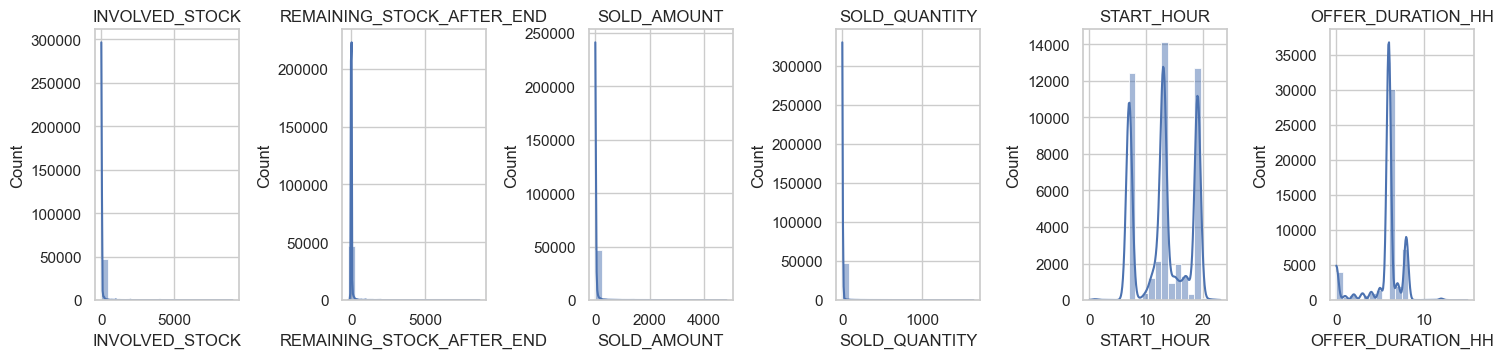

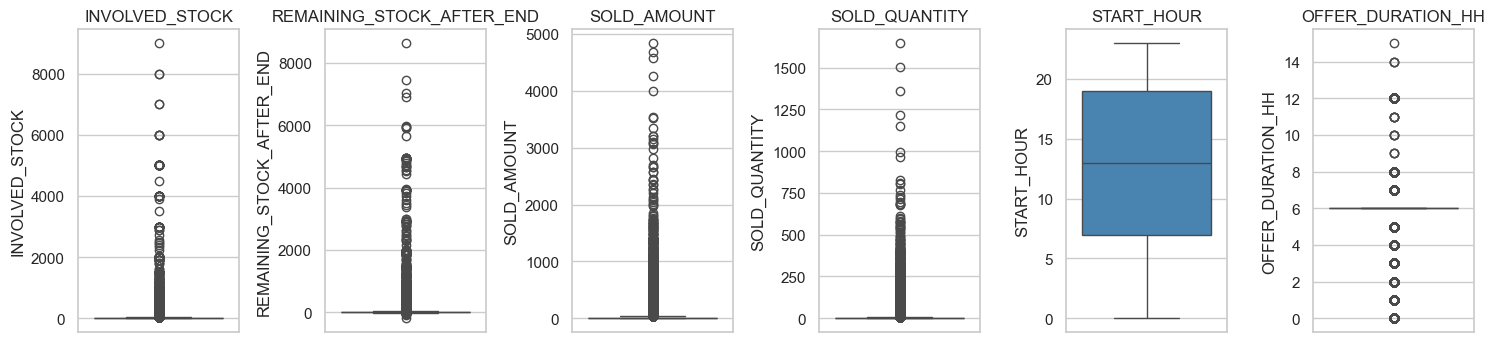

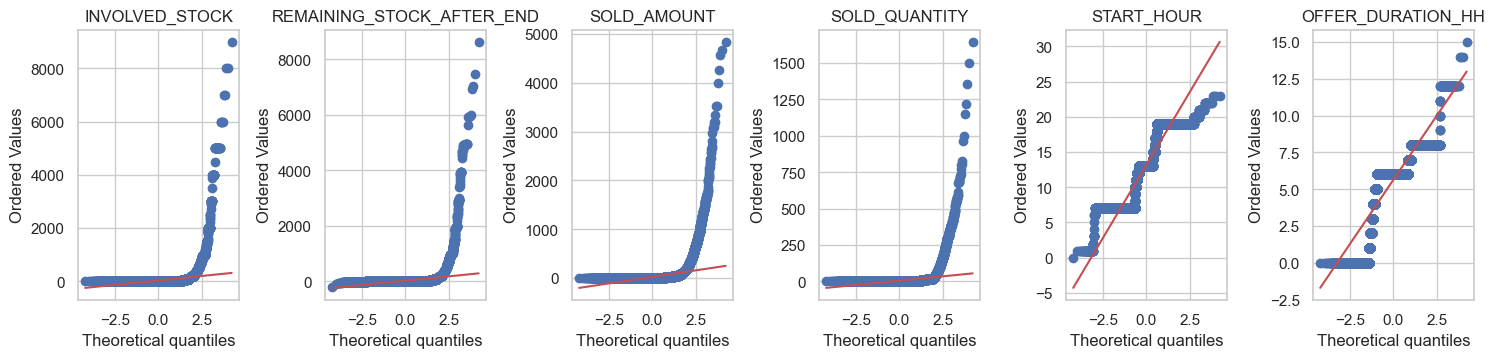

In [12]:
# Visualizaciones

sns.set(style='whitegrid')

# Histogramas

plt.figure(figsize=(15, 10))
for i, var in enumerate(all_numerical_columns):
    plt.subplot(3, 6, i + 1)
    sns.histplot(data[var], kde=True, bins=20,palette='Blues_d')
    plt.title(var)
plt.tight_layout()
plt.show()

# Boxplot
plt.figure(figsize=(15, 10))
for i, var in enumerate(all_numerical_columns):
    plt.subplot(3, 6, i + 1)
    sns.boxplot(y=data[var],palette='Blues_d')
    plt.title(var)
plt.tight_layout()
plt.show()

# QQ-plot
plt.figure(figsize=(15, 10))
for i, var in enumerate(all_numerical_columns):
    plt.subplot(3, 6, i + 1)
    stats.probplot(data[var], dist='norm', plot=plt)
    plt.title(var)
plt.tight_layout()
plt.show()

Se procede a revisar las posibles relaciones entre estas variables. Se revisan los gráficos de dispersión y las correlaciones para encontrar una relación lineal entre el stock involucrado y el restante como es de esperarse. Entre estas dos caracteristicas se vé una correlacion importante en los alrededores del 0.5, mostrando una posible relación enter los stocks y las ventas finales.

<Figure size 600x300 with 0 Axes>

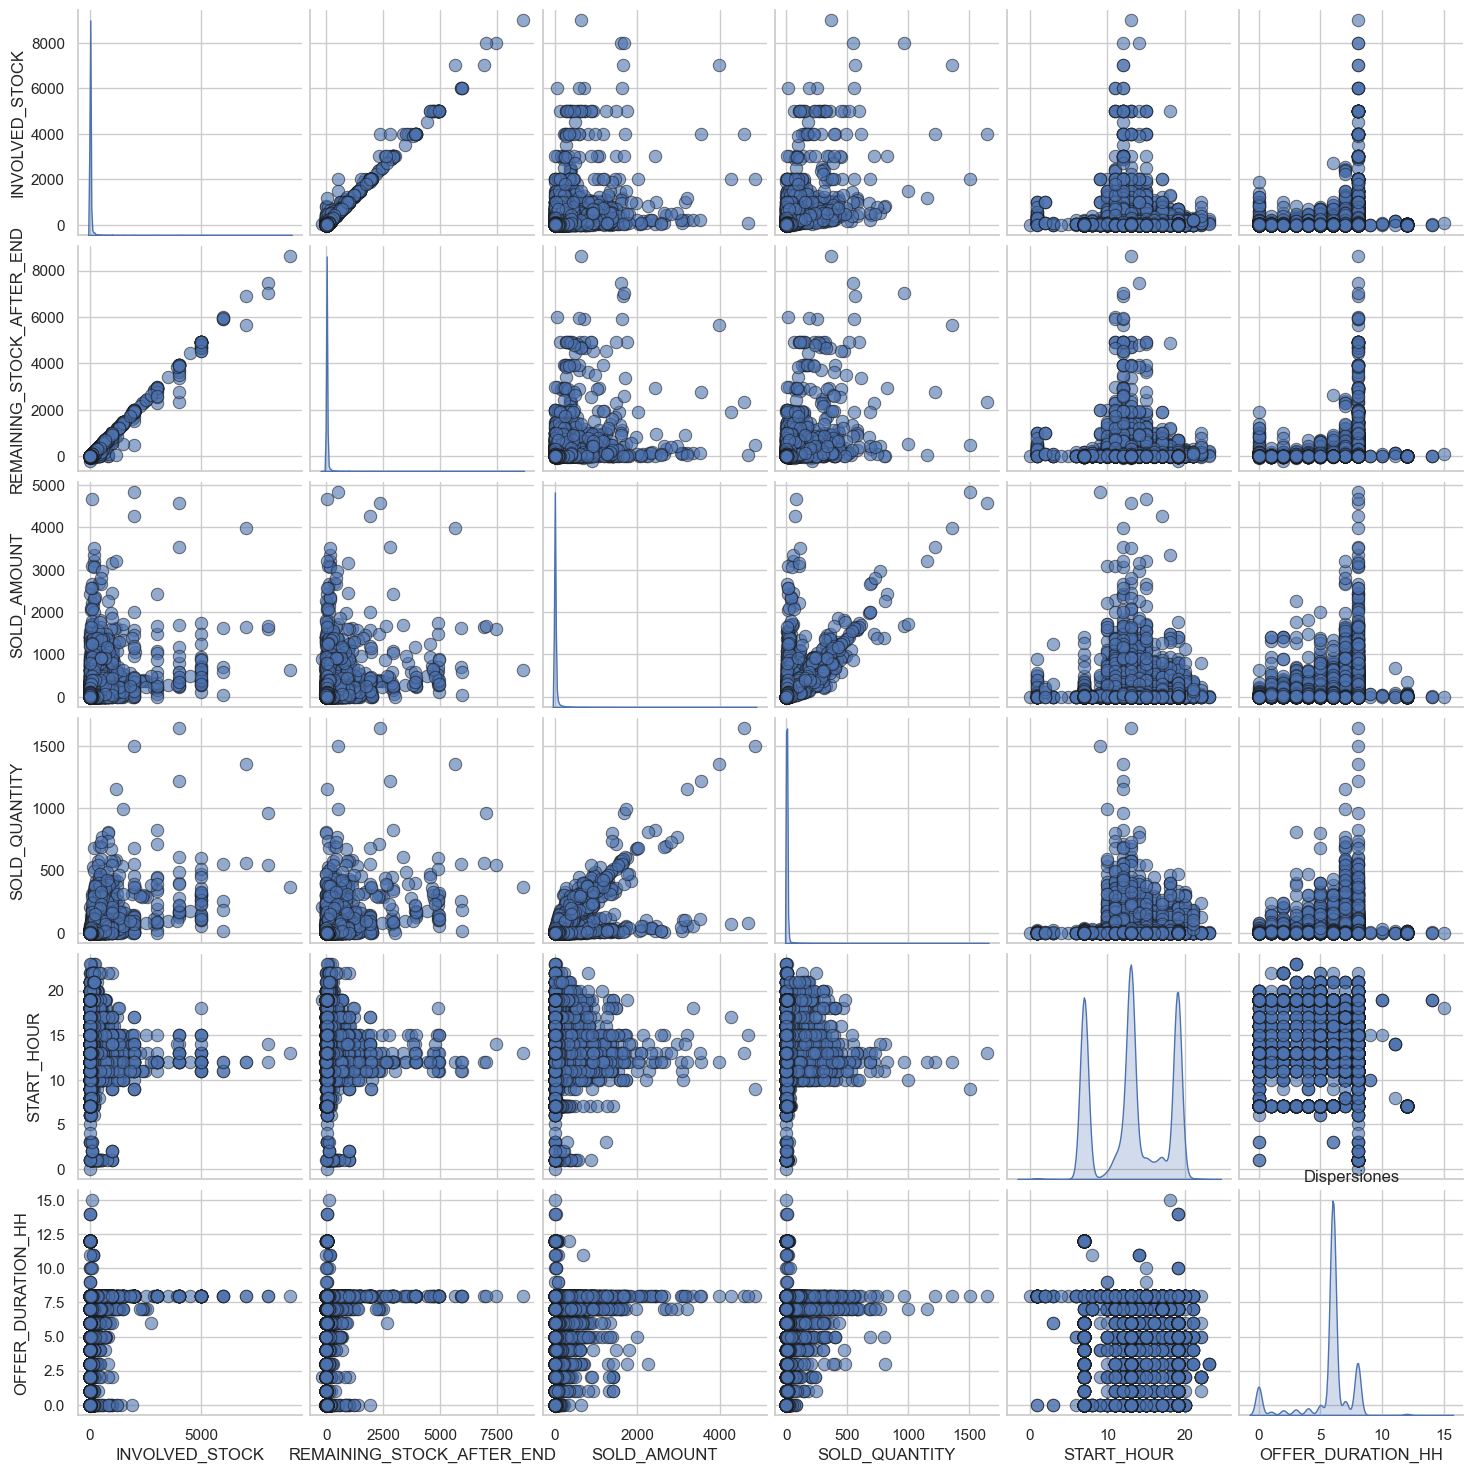

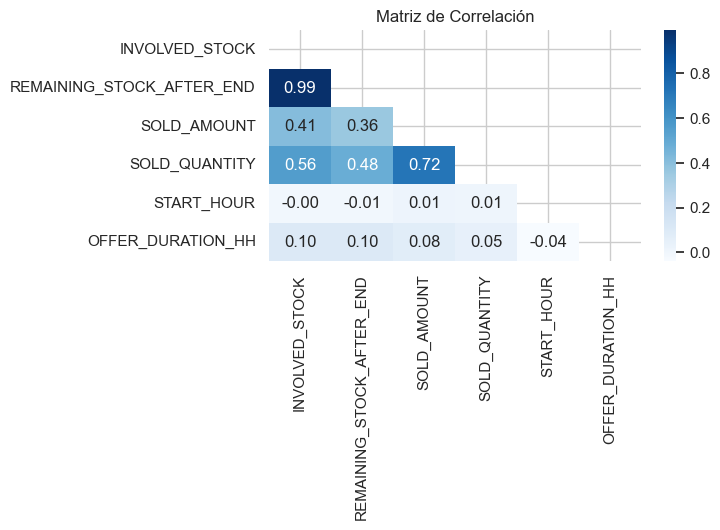

In [13]:
# Scatter
plt.figure(figsize=(6, 3))
sns.pairplot(data[all_numerical_columns], diag_kind='kde', plot_kws={'alpha':0.6, 's':80, 'edgecolor':'k'}, diag_kws={'shade': True},palette='Blues_d')
plt.title('Dispersiones', fontsize=12)
plt.show()

# Correlación
corr = data[all_numerical_columns].corr()
matrix = np.triu(corr)

sns.set(style='whitegrid')

plt.figure(figsize=(6, 3))
sns.heatmap(corr
            , annot=True
            , mask=matrix
            , fmt='.2f'
            , cmap='Blues'
           )
plt.title('Matriz de Correlación', fontsize=12)
plt.show()


Repecto a los tiempos, aunque el coeficiente de correlación no es alto se pueden ver unos rangos en los que el inicio de una oferta muestra mayores ventas. Se genera una categorización para estas variables. Para ver esas relaciones se grafican las variables de tiempo frente a las ventas:

In [14]:
def categorize_offer_start_time(start_time):
    hour = start_time.hour
    if hour >= 23 or hour < 10:
        return '11 pm - 9 am'
    elif 10 <= hour < 14:
        return '10 am - 1 pm'
    elif 14 <= hour < 18:
        return '2 pm - 5 pm'
    else:  # 18 <= hour < 22
        return '6 pm - 10 pm'
data['OFFER_START_CATEGORY'] = data['OFFER_START_DTTM'].apply(categorize_offer_start_time)

def categorize_duration(hours):
    if hours <= 2:
        return '0-2 horas'
    if hours <= 6:
        return '3-6 horas'
    elif hours <= 8:
        return '7-8 horas'
    else:
        return 'Más de 8 horas'
data['OFFER_DURATION_CATEGORY'] = data['OFFER_DURATION_HH'].apply(categorize_duration)

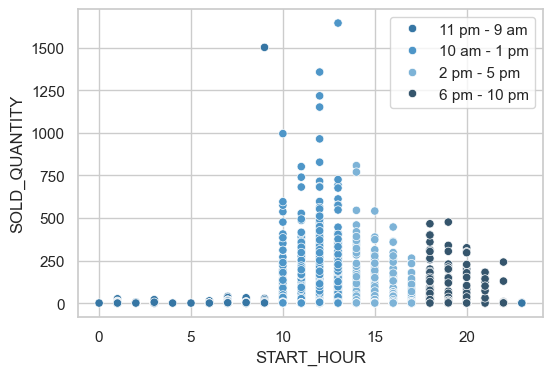

In [15]:
plt.figure(figsize=(6, 4))
ax = sns.scatterplot(data=data, x='START_HOUR', y='SOLD_QUANTITY', hue='OFFER_START_CATEGORY', palette = 'Blues_d')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

handles, labels = plt.gca().get_legend_handles_labels()
order = [2, 1, 0, 3] 
plt.legend([handles[i] for i in order], [labels[i] for i in order]) 

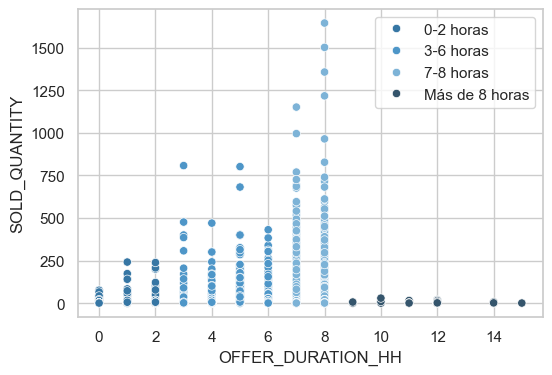

In [16]:
plt.figure(figsize=(6, 4))
ax = sns.scatterplot(data=data, x='OFFER_DURATION_HH', y='SOLD_QUANTITY', hue='OFFER_DURATION_CATEGORY', palette = 'Blues_d')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

handles, labels = plt.gca().get_legend_handles_labels()
order = [2, 1, 0, 3] 
plt.legend([handles[i] for i in order], [labels[i] for i in order])

#### Cualitativas

In [17]:
categorical_columns = list(data.select_dtypes(include=['object']).columns)
categorical_columns = [cols for cols in categorical_columns if cols not in ['OFFER_TYPE'
                                                                            ,'DOMAIN_ID'
                                                                            ]
                      ]

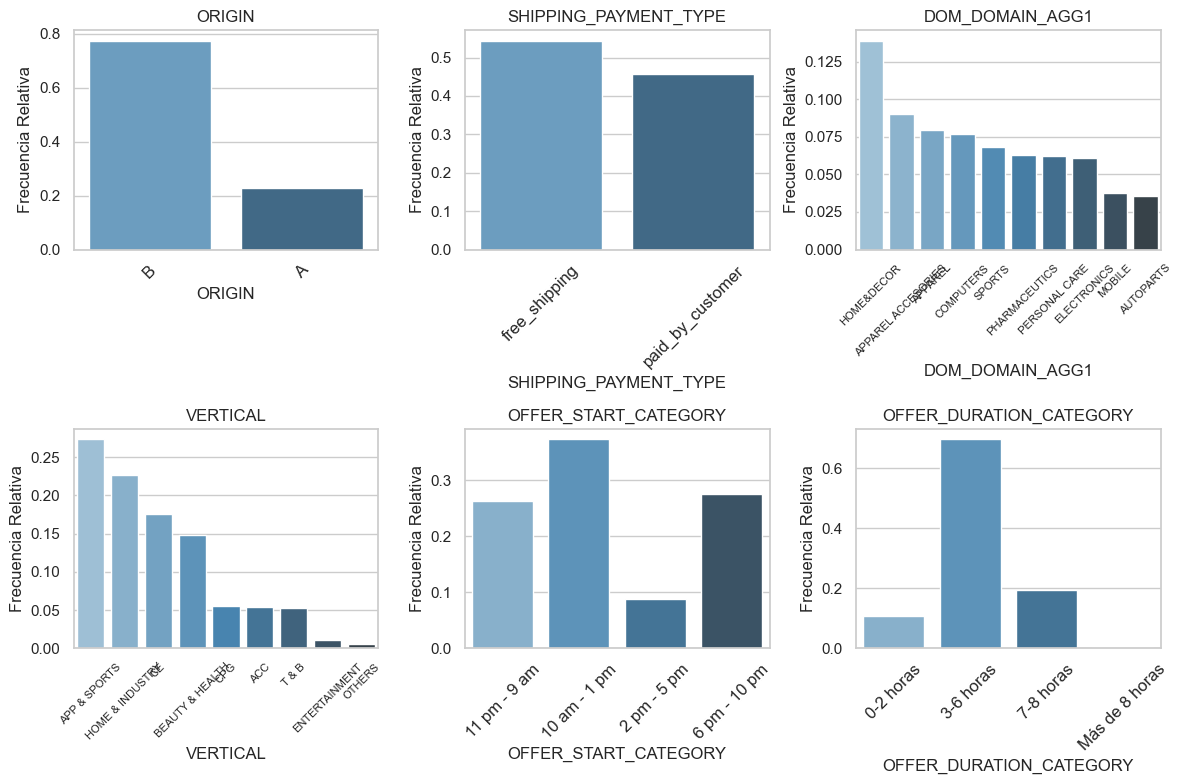

In [18]:
plt.figure(figsize=(12, 8))

for i, var in enumerate(categorical_columns):
    plt.subplot(2, 3, i + 1)
    sns.barplot(x=data[var].value_counts()[:10].index
                , y=data[var].value_counts(normalize=True)[:10]
                ,palette='Blues_d'
                ,order=(['11 pm - 9 am', '10 am - 1 pm', '2 pm - 5 pm', '6 pm - 10 pm'] if var=='OFFER_START_CATEGORY'
                        else ['0-2 horas', '3-6 horas', '7-8 horas', 'Más de 8 horas'] if var=='OFFER_DURATION_CATEGORY'
                        else list(data[var].value_counts()[:10].index)
                       )
               )
    plt.title(var)
    plt.ylabel('Frecuencia Relativa')
    plt.xticks(rotation=45, fontsize = (8 if var in ['DOM_DOMAIN_AGG1', 'VERTICAL'] else 12))


plt.tight_layout()
plt.show()


Se observa que casi 4 quintas partes de las ofertas son puestas por terceros y solo 1 quinto es propia de mercado libre. Los rangos de ofertas con envíos gratis y los que no son muy parecidos. Las verticales en las que hay mayores ofertas es en ropa y deportes, hogar e industria, electrónica y computación y belleza y salud. Es importante recalcar que la única categoría que tiene más del 10% de las ofertas relámpago es la de hogar y decoración. Por otro lado, en las variables de hora de incio se ve que hay la mayoria de las ofertas se hacen a medio día o inciando la noche y la duracion de estas ofertas suelen estar entre 3 y 6 horas.

In [19]:
# Coeficientes de relacionamiento e independencia

contingency_tables = {}
for var_pair in itertools.combinations(categorical_columns, 2):
    contingency_table = pd.crosstab(data[var_pair[0]], data[var_pair[1]])
    contingency_tables[var_pair] = contingency_table


def cramers_v(confusion_matrix):
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2_corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    r_corr = r - ((r-1)**2)/(n-1)
    k_corr = k - ((k-1)**2)/(n-1)
    return (phi2_corr / min((k_corr-1), (r_corr-1)))**0.5

cramer_chi2_results = []
for var_pair in itertools.combinations(categorical_columns, 2):
    table = contingency_tables[var_pair]
    chi2, p, _, _ = chi2_contingency(table)
    cramer_v_value = cramers_v(table)
    cramer_chi2_results.append({
        'Columna_1': var_pair[0],
        'Columna_2': var_pair[1],
        'Coeficiente_Cramer': cramer_v_value,
        'Valor_P_Chi2': p
    })

cramer_chi2_df = pd.DataFrame(cramer_chi2_results)
cramer_chi2_df.sort_values(by='Coeficiente_Cramer')

,Columna_1,Columna_2,Coeficiente_Cramer,Valor_P_Chi2
7,SHIPPING_PAYMENT_TYPE,OFFER_START_CATEGORY,0.084715,1.000510e-74
13,VERTICAL,OFFER_DURATION_CATEGORY,0.095589,4.361822e-267
0,ORIGIN,SHIPPING_PAYMENT_TYPE,0.097058,3.457705e-100
8,SHIPPING_PAYMENT_TYPE,OFFER_DURATION_CATEGORY,0.104604,9.826781e-114
12,VERTICAL,OFFER_START_CATEGORY,0.123311,0.000000e+00
6,SHIPPING_PAYMENT_TYPE,VERTICAL,0.143336,1.719255e-208
11,DOM_DOMAIN_AGG1,OFFER_DURATION_CATEGORY,0.162525,0.000000e+00
2,ORIGIN,VERTICAL,0.192158,0.000000e+00
10,DOM_DOMAIN_AGG1,OFFER_START_CATEGORY,0.194859,0.000000e+00
5,SHIPPING_PAYMENT_TYPE,DOM_DOMAIN_AGG1,0.277455,0.000000e+00


Por otro lado se puede observar que se puede ver que todas las variables cualitativas no son independientes y que su relacionamiento es moderado a alto según el coeficiente de Cramer.

#### Conjuntas

Para ver la relación de las categorias en las ventas se observan las distribuciones de cantidades vendidas respecto a las diferentes categorías:

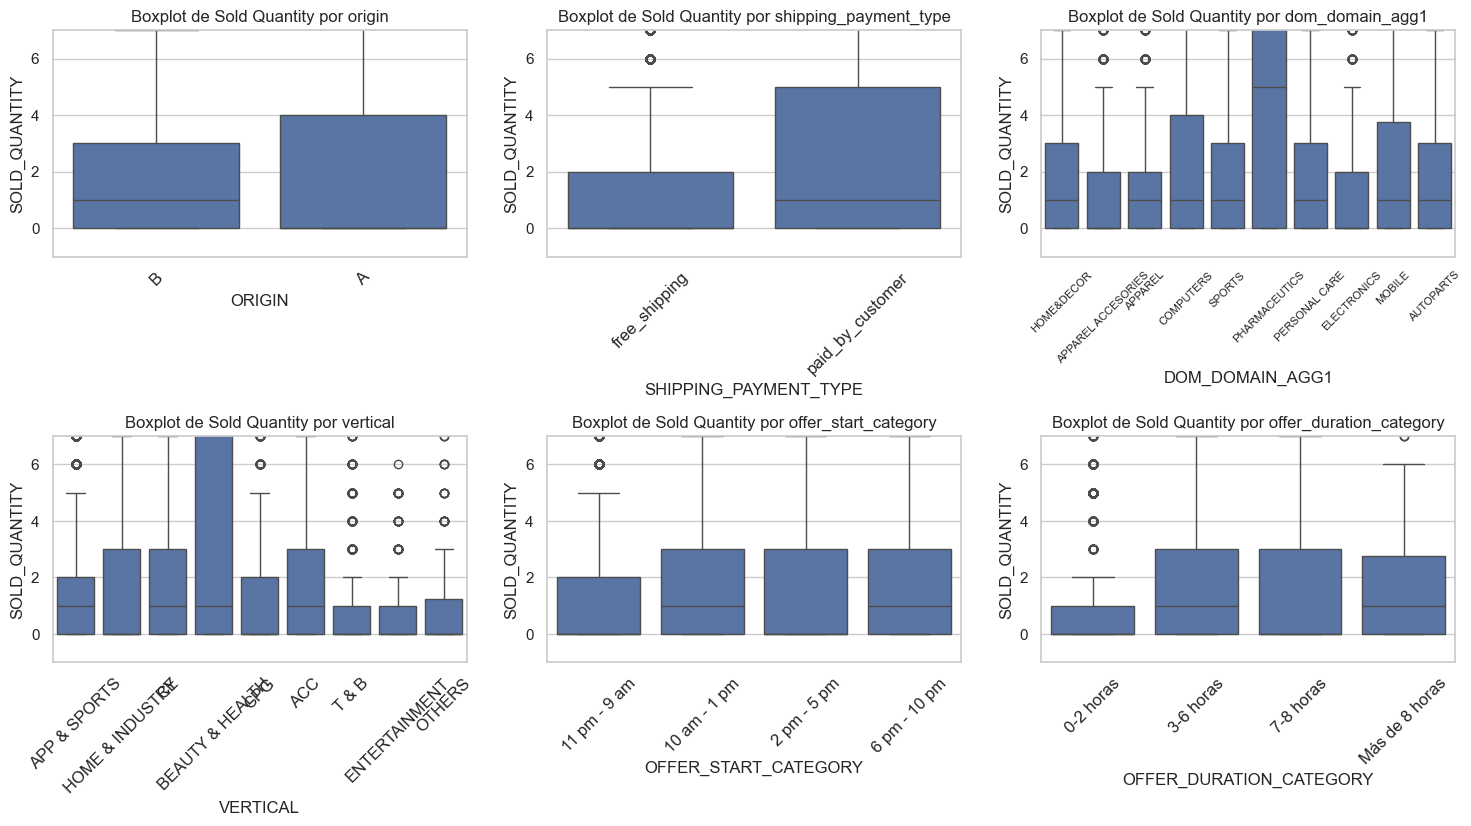

In [20]:
# Boxplot agrupados

percentile_95 = data['SOLD_QUANTITY'].quantile(0.90)

# Crear boxplots limitados a los percentiles 5 y 95
plt.figure(figsize=(15, 15))

for i, var in enumerate(categorical_columns):
    plt.subplot(4, 3, i + 1)
    sns.boxplot(x=data[data[var].isin(list(data[var].value_counts()[:10].index)) if var=='DOM_DOMAIN_AGG1' else data[var].apply(lambda x: True)][var]
                , y=data['SOLD_QUANTITY']
                ,order=(['11 pm - 9 am', '10 am - 1 pm', '2 pm - 5 pm', '6 pm - 10 pm'] if var=='OFFER_START_CATEGORY'
                        else ['0-2 horas', '3-6 horas', '7-8 horas', 'Más de 8 horas'] if var=='OFFER_DURATION_CATEGORY'
                        else list(data[var].value_counts()[:10].index)
                       )
               )
    plt.ylim(-1, percentile_95)
    plt.title(f'Boxplot de Sold Quantity por {var.lower()}')
    plt.xticks(rotation=45, fontsize = (8 if var == 'DOM_DOMAIN_AGG1' else 12))

plt.tight_layout()
plt.show()


In [21]:
# ANOVA
anova_summary = []

for var in categorical_columns:
    model = ols(f'SOLD_QUANTITY ~ C({var})', data=data).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    f_value = anova_table.loc['C(' + var + ')', 'F']
    p_value = anova_table.loc['C(' + var + ')', 'PR(>F)']
    anova_summary.append({
        'Variable': var,
        'F Value': f_value,
        'P Value': p_value
    })

anova_summary_df = pd.DataFrame(anova_summary)
anova_summary_df


,Variable,F Value,P Value
0,ORIGIN,1841.299804,0.000000e+00
1,SHIPPING_PAYMENT_TYPE,507.353331,9.134902e-112
2,DOM_DOMAIN_AGG1,194.401582,0.000000e+00
3,VERTICAL,390.354302,0.000000e+00
4,OFFER_START_CATEGORY,156.304830,8.106680e-101
5,OFFER_DURATION_CATEGORY,343.745407,7.159294e-221


Estadísticamente todas las variables categóricas tienen una relación significativa con las cantidades vendidas. Adicionalmente, se observa que el origen de mercado libre aunque tienen una mediana más pequeña respecto a las de terceros pueden tener un mayor potencial de ventas. El tipo de envío pagado por el cliente suele tener una mayor cantidad para la mayoría de cuantiles. Por el lado de las categorias más ofrecidas, los productos de belleza tiene una mediana de al menos 5 más ventas que las demás, lo que impulsa las vertical de belleza. Por otro lado en las categorías de tiempo, solo se observa que hay dos horas de inicio valle de 2 a 5 pm y de 11 pm a 9 am, así como que las ofertas de 0 a 2 horas y de 7 a 8 horas también tienen un comportamiento menor al de 3 a 6 horas y mayores a 8 horas.

### 4. Series de Tiempo

Teniendo en cuenta el comportamiento general de las ofertas, ahora se centrará en las ofertas por día. Para esto, se agrupa la información de cantidades vendidas, ventas totales y stock incial (se remueve el stock restante debido a la alta correlación con el stock inicial); para el total de la base y discriminando todas las variables categoricas anteriormente estudiadas para ver su impacto agregado en el tiempo.

In [22]:
grouped_data = data.groupby('OFFER_START_DATE').agg({
    'SOLD_QUANTITY': 'sum',
    'SOLD_AMOUNT': 'sum',
    'INVOLVED_STOCK': 'sum',
}).reset_index()

def add_category_aggregations(df, category):
    # Creando un dataframe temporal para la categoría específica
    temp_df = data.groupby(['OFFER_START_DATE', category]).agg({
        'SOLD_QUANTITY': 'sum'
    }).unstack(fill_value=0)
    
    temp_df.columns = [f'{category}_{val}_{col}' for val, col in temp_df.columns]
    
    return df.join(temp_df, on='OFFER_START_DATE')

# Aplicando la función para cada categoría
categories = ['ORIGIN', 'SHIPPING_PAYMENT_TYPE', 'VERTICAL', 'DOM_DOMAIN_AGG1', 'OFFER_DURATION_CATEGORY', 'OFFER_START_CATEGORY']
for category in categories:
    grouped_data = add_category_aggregations(grouped_data, category)

grouped_data = grouped_data.set_index('OFFER_START_DATE')
grouped_data['OFFERS_NUMBER'] = data.groupby('OFFER_START_DATE')['OFFER_START_DATE'].agg('count')

grouped_data.head()

,SOLD_QUANTITY,SOLD_AMOUNT,INVOLVED_STOCK,ORIGIN_SOLD_QUANTITY_A,ORIGIN_SOLD_QUANTITY_B,SHIPPING_PAYMENT_TYPE_SOLD_QUANTITY_free_shipping,SHIPPING_PAYMENT_TYPE_SOLD_QUANTITY_paid_by_customer,VERTICAL_SOLD_QUANTITY_ACC,VERTICAL_SOLD_QUANTITY_APP & SPORTS,VERTICAL_SOLD_QUANTITY_BEAUTY & HEALTH,...,DOM_DOMAIN_AGG1_SOLD_QUANTITY_WHEELS & TIRES,OFFER_DURATION_CATEGORY_SOLD_QUANTITY_0-2 horas,OFFER_DURATION_CATEGORY_SOLD_QUANTITY_3-6 horas,OFFER_DURATION_CATEGORY_SOLD_QUANTITY_7-8 horas,OFFER_DURATION_CATEGORY_SOLD_QUANTITY_Más de 8 horas,OFFER_START_CATEGORY_SOLD_QUANTITY_10 am - 1 pm,OFFER_START_CATEGORY_SOLD_QUANTITY_11 pm - 9 am,OFFER_START_CATEGORY_SOLD_QUANTITY_2 pm - 5 pm,OFFER_START_CATEGORY_SOLD_QUANTITY_6 pm - 10 pm,OFFERS_NUMBER
OFFER_START_DATE,,,,,,,,,,,,,,,,,,,,,
2021-06-01,2902.0,14943.98,23529,1805.0,1097.0,457.0,2445.0,41.0,257.0,1903.0,...,1.0,123.0,1984.0,795.0,0.0,1091.0,286.0,856.0,669.0,875
2021-06-02,2387.0,11428.76,22178,1709.0,678.0,466.0,1921.0,9.0,207.0,1573.0,...,0.0,80.0,1336.0,971.0,0.0,1386.0,158.0,576.0,267.0,665
2021-06-03,2970.0,15695.98,21995,2166.0,804.0,754.0,2216.0,68.0,243.0,2015.0,...,0.0,51.0,1828.0,1091.0,0.0,1315.0,183.0,774.0,698.0,504
2021-06-04,1750.0,8765.48,14208,996.0,754.0,516.0,1234.0,14.0,206.0,1046.0,...,0.0,131.0,1204.0,415.0,0.0,804.0,236.0,352.0,358.0,457
2021-06-05,1943.0,11322.16,14151,1223.0,720.0,521.0,1422.0,49.0,378.0,1028.0,...,0.0,52.0,1190.0,701.0,0.0,810.0,238.0,627.0,268.0,428


Se generan entonces las visualizaciones de series de tiempo para darnos una idea del comportamiento inicial de las ventas y stock para ver patrones y posibles relaciones:

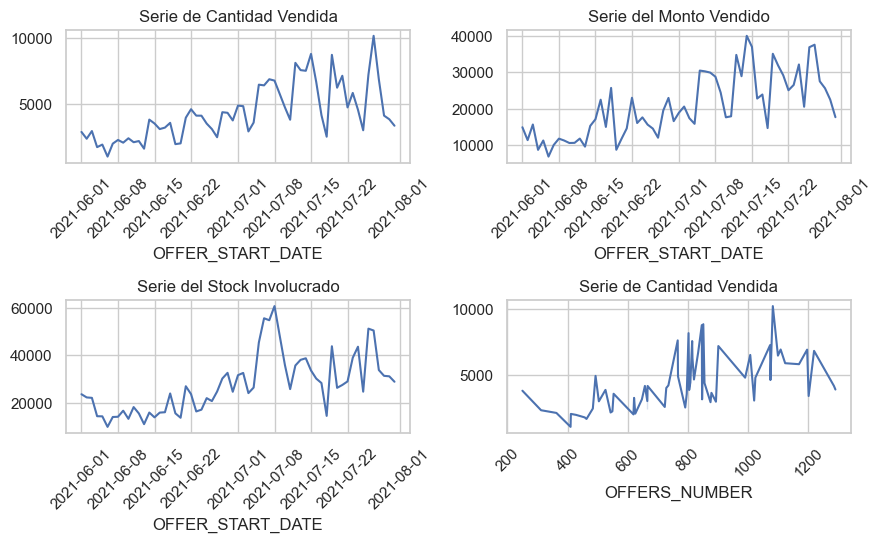

In [23]:
sns.set(style="whitegrid")

plt.figure(figsize=(9, 10))

# Serie de la Cantidad Vendida
plt.subplot(4, 2, 1)
sns.lineplot(x='OFFER_START_DATE', y='SOLD_QUANTITY', data=grouped_data)
plt.title('Serie de Cantidad Vendida')
plt.xticks(rotation=45)
plt.ylabel('')

# Serie del Monto Vendido
plt.subplot(4, 2, 2)
sns.lineplot(x='OFFER_START_DATE', y='SOLD_AMOUNT', data=grouped_data)
plt.title('Serie del Monto Vendido')
plt.xticks(rotation=45)
plt.ylabel('')

# Serie del Stock Involucrado
plt.subplot(4, 2, 3)
sns.lineplot(x='OFFER_START_DATE', y='INVOLVED_STOCK', data=grouped_data)
plt.title('Serie del Stock Involucrado')
plt.xticks(rotation=45)
plt.ylabel('')

# Serie de la Cantidad Vendida
plt.subplot(4, 2, 4)
sns.lineplot(x='OFFERS_NUMBER', y='SOLD_QUANTITY', data=grouped_data)
plt.title('Serie de Cantidad Vendida')
plt.xticks(rotation=45)
plt.ylabel('')

plt.tight_layout()
plt.show()



Como es de esperarse el monto de ventas esta muy relacionado con la cantidad vendida y aunque tambien guarda una relación con el stock, este último puede fluctuar de manera que no afecte en la misma medida a las cantidades. Asi mismo, se ve en todas una tendencia positiva y ve un comportamiento estacional semanal. Para comporbarlo, se descompone la serie según un modelo aditivo (de varianza estacional constante):

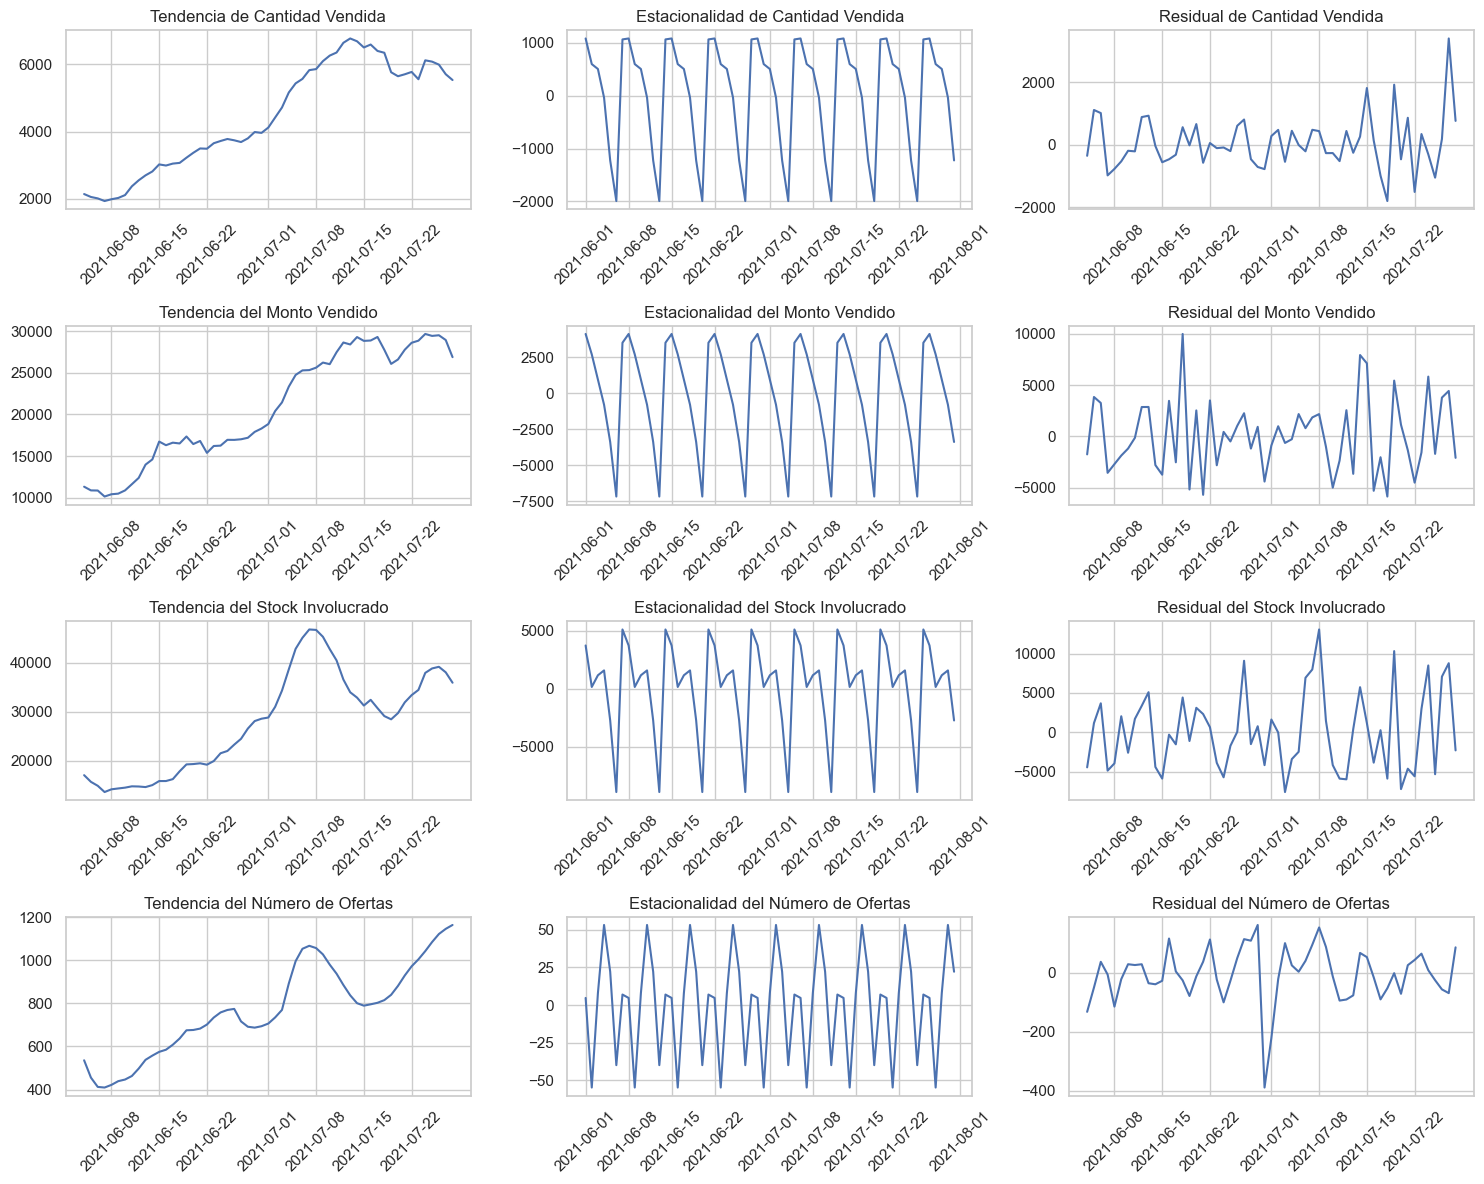

In [24]:
decomposition_quantity = sm.tsa.seasonal_decompose(grouped_data['SOLD_QUANTITY'], model='additive', period=7)
decomposition_amount = sm.tsa.seasonal_decompose(grouped_data['SOLD_AMOUNT'], model='additive', period=7)
decomposition_stock = sm.tsa.seasonal_decompose(grouped_data['INVOLVED_STOCK'], model='additive', period=7)
decomposition_offers = sm.tsa.seasonal_decompose(grouped_data['OFFERS_NUMBER'], model='additive', period=7)

plt.figure(figsize=(15, 12))

# Cantidad Vendida
plt.subplot(4, 3, 1)
plt.plot(decomposition_quantity.trend)
plt.title('Tendencia de Cantidad Vendida')
plt.xticks(rotation=45)
plt.subplot(4, 3, 2)
plt.plot(decomposition_quantity.seasonal)
plt.title('Estacionalidad de Cantidad Vendida')
plt.xticks(rotation=45)
plt.subplot(4, 3, 3)
plt.plot(decomposition_quantity.resid)
plt.title('Residual de Cantidad Vendida')
plt.xticks(rotation=45)

# Monto Vendido
plt.subplot(4, 3, 4)
plt.plot(decomposition_amount.trend)
plt.title('Tendencia del Monto Vendido')
plt.xticks(rotation=45)
plt.subplot(4, 3, 5)
plt.plot(decomposition_amount.seasonal)
plt.title('Estacionalidad del Monto Vendido')
plt.xticks(rotation=45)
plt.subplot(4, 3, 6)
plt.plot(decomposition_amount.resid)
plt.title('Residual del Monto Vendido')
plt.xticks(rotation=45)

# Stock Involucrado
plt.subplot(4, 3, 7)
plt.plot(decomposition_stock.trend)
plt.title('Tendencia del Stock Involucrado')
plt.xticks(rotation=45)
plt.subplot(4, 3, 8)
plt.plot(decomposition_stock.seasonal)
plt.title('Estacionalidad del Stock Involucrado')
plt.xticks(rotation=45)
plt.subplot(4, 3, 9)
plt.plot(decomposition_stock.resid)
plt.title('Residual del Stock Involucrado')
plt.xticks(rotation=45)

# Ofertas
plt.subplot(4, 3, 10)
plt.plot(decomposition_offers.trend)
plt.title('Tendencia del Número de Ofertas')
plt.xticks(rotation=45)
plt.subplot(4, 3, 11)
plt.plot(decomposition_offers.seasonal)
plt.title('Estacionalidad del Número de Ofertas')
plt.xticks(rotation=45)
plt.subplot(4, 3, 12)
plt.plot(decomposition_offers.resid)
plt.title('Residual del Número de Ofertas')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Al corroborar con la descomposición el comportamiento descrito anteriormente, ahora se buscan los factores que más pueden estar afectando las cantidades vendidas, a partir de los tipos de ofertas colocadas según las categorías anteriormente analizadas. Por lo cual, primero se observa la dispersión entre cada categoría respecto a las cantidades y así darnos una idea del comportamiento que puedan tener:

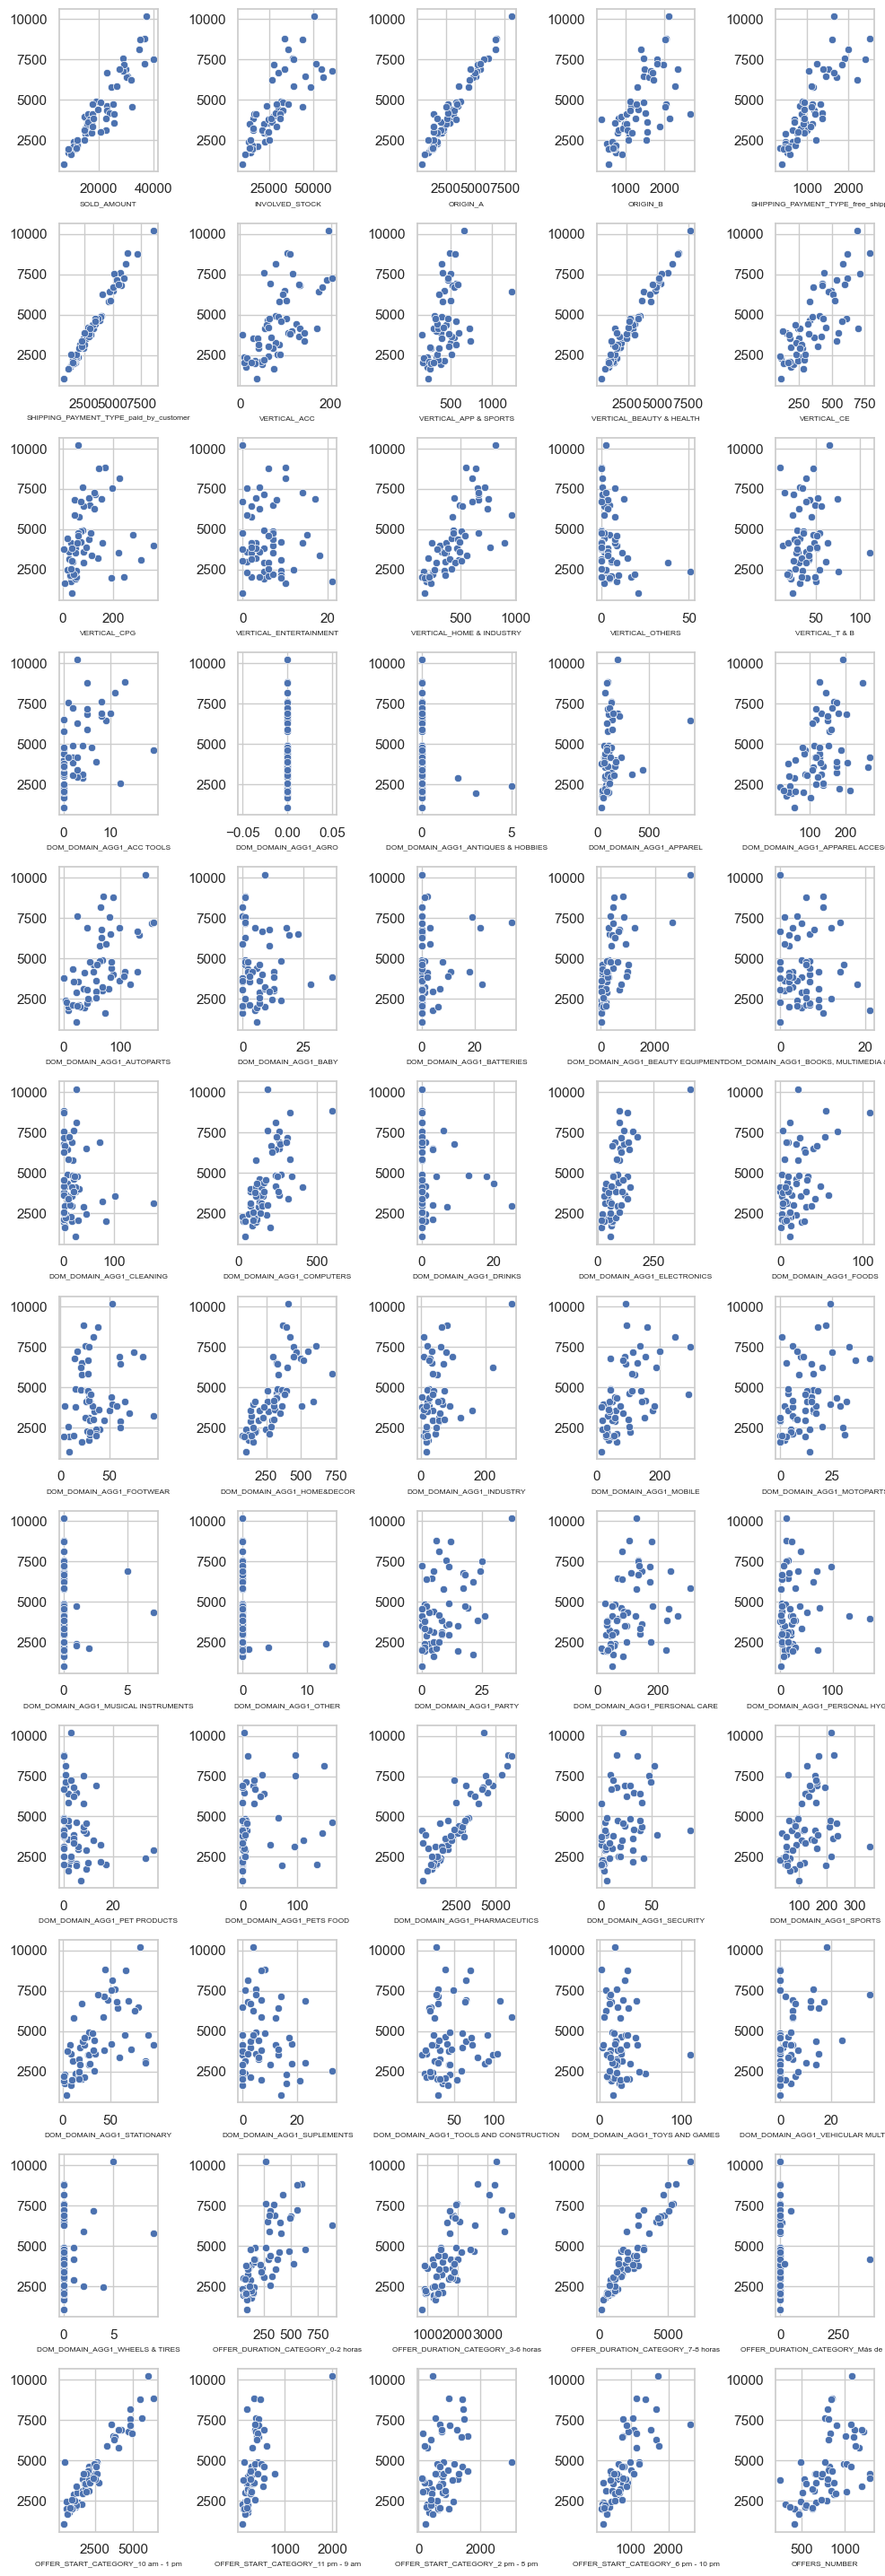

In [25]:
plt.figure(figsize=(10, 50))

for i, var in enumerate(grouped_data.columns[1:]):
    plt.subplot(21, 5, i + 1)
    sns.scatterplot(x=grouped_data[var]
                , y=grouped_data['SOLD_QUANTITY']
                ,palette='Blues_d'
               )
    # plt.title(var)
    plt.ylabel('')
    plt.xlabel(var.replace('SOLD_QUANTITY_', ''), fontsize=6)
    


plt.tight_layout()
plt.show()

Dejando de parte la relación esperada entre el stock puesto, el volumen de ventas y el número de ventas, se puede observar un como las categorías en el análisis por ofertas aquí tienen un comportamiento más consistente respecto a las ventas:

 - Ofertas que inician fuera de las horas valle.
 - Ofertas de 7 a 8 horas.
 - Categorías como farmacias, vestuario y electrónicos.
 - De la misma forma sus verticales contienen estos efectos.
 - Se ve mucho más marcada la linealidad en las relaciones de las ofertas pagadas por el cliente y que son originarias del propio mercado libre.

Hay categorias que por el contrario su influencia respeto al total de unidades vendidas es marginal. Por otro lado hay variables que si pueden afectar el total, pero su relacion no es lineal como puede ser el caso de las ofertas que se son de dos horas o menos. En estos casos para realizar un modelo lineal convendría realizar las modificaciones de escala sobre la variable.

Por último se analizan las correlaciones entre cada categoría para ver cuales podrían ayudar tener una mayor relacion con la cantidad de ventas:

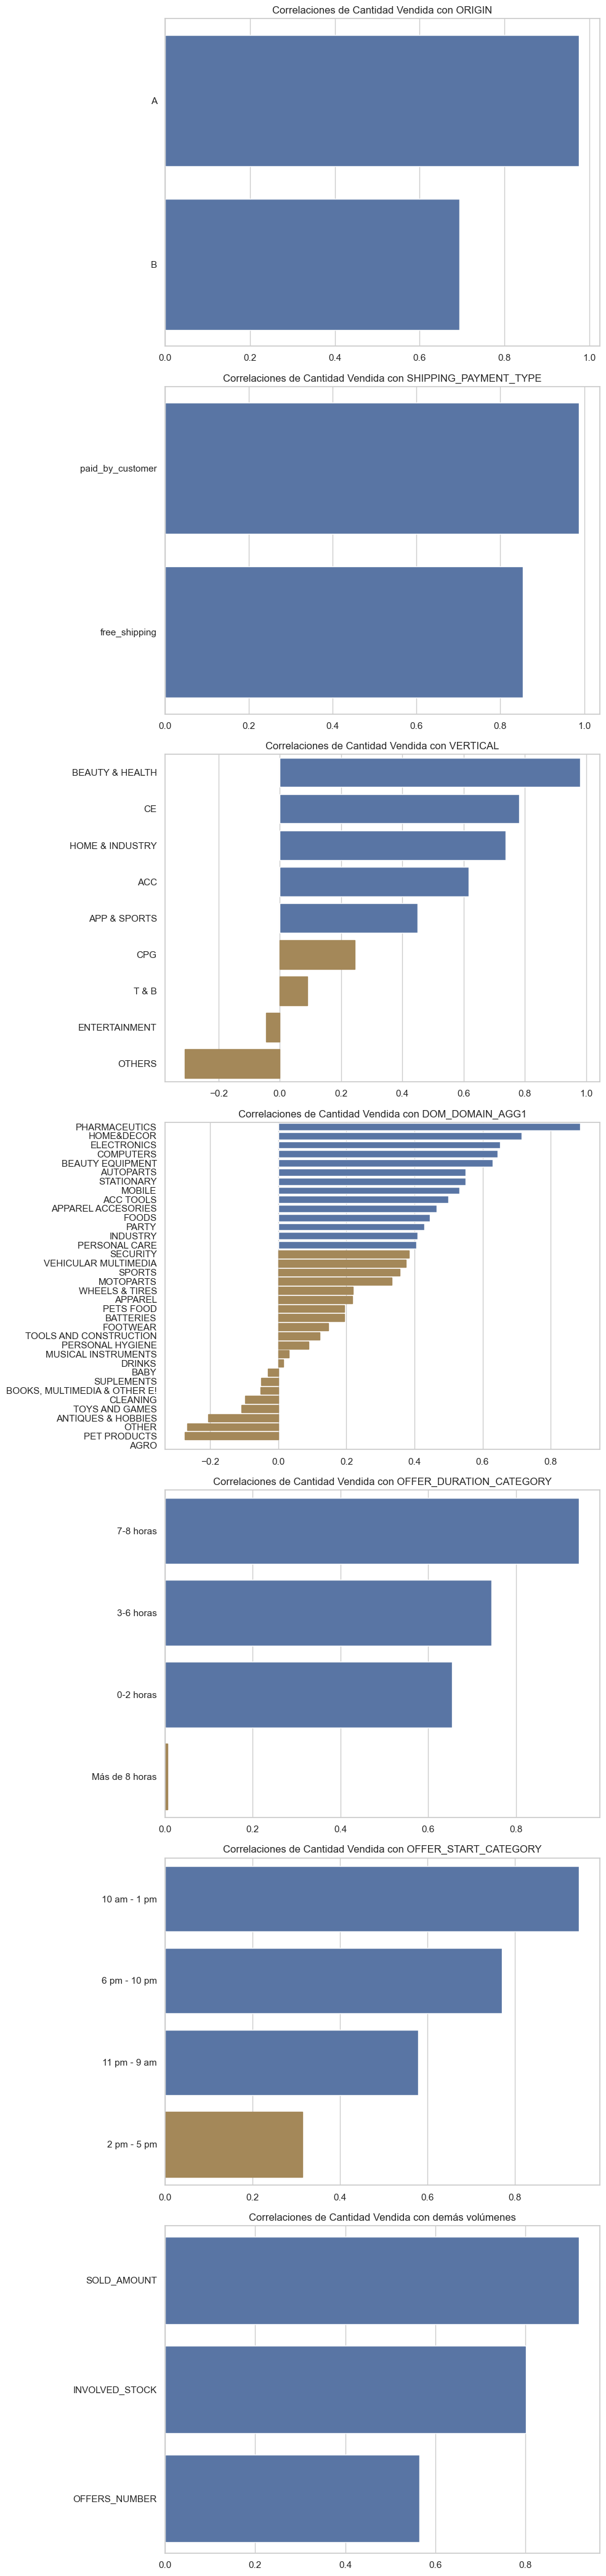

In [26]:
correlation_matrix = grouped_data.corr()

correlation_matrix = correlation_matrix['SOLD_QUANTITY'].sort_values(ascending=False)

fig, axs = plt.subplots(len(categories) + 1, 1, figsize=(10, 7 * len(categories))) # Ajustar la altura según la cantidad de categorías

for i, category in enumerate(categories):
    category_correlations = correlation_matrix[correlation_matrix.index.str.contains(f'{category}_')]
        
    ax = axs[i]

    barplot = sns.barplot(y=[item.replace('_SOLD_QUANTITY','').replace(f'{category}_','') for item in list(category_correlations.index)]
                          ,x=category_correlations.values
                          ,ax=ax
                         )
    ax.set_title(f'Correlaciones de Cantidad Vendida con {category}')
    
    for bar in barplot.patches:
        if bar.get_width() < 0.4:
            bar.set_color('#A48859')

ax = axs[len(categories)]
barplot = sns.barplot(y=correlation_matrix[['SOLD_AMOUNT', 'INVOLVED_STOCK', 'OFFERS_NUMBER']].index
                      ,x=correlation_matrix[['SOLD_AMOUNT', 'INVOLVED_STOCK', 'OFFERS_NUMBER']].values
                      ,ax=ax
                      )
ax.set_title(f'Correlaciones de Cantidad Vendida con demás volúmenes')
ax.set_ylabel('')


plt.tight_layout()
plt.show()

### 5. Conclusión

En general se reviso las 47.820 ofertas realizadas encontrando algunos patrones de estas dependiendo de quien es el oferente, lo que se está vendiendo y cuando se está vendiendo. No tanto respecto a la cantidad de ofertas que se generen en el día. Se puede observar que para la mayoria de categorías propuestas existe una correlación con la cantidad de ventas. Ahora bien, variables como el tipo de envio no parecen dar un tener una gran incidencia en las cantidades vendidas (Puede ser un efecto pandemia debido al periodo analizado). Solo algunas categorías de ventas y las ofertas que inician de 2 a 5 pm no parecen tener una correlación fuerte con la cantidad de ventas. Hay que tener en cuenta que estas variables pueden cambiar su comportamiento si se cambia su escala.

Por último, recomendar los pasos a seguir: Descartar variables con información redundante que puedan entorpecer la explicación de las cantidades. Así mismo probar combinaciones de categorías de datos para generar variables más potentes y generarlas a partir de metodologías de clusterización más precisas. Descartar para la etapa de modelado las variables que desde aquí se ven que no tienen ningún poder de explicación del la variable objetivo y también tratar de darles un contexto de negocio a las relaciones que se encuentren.

Muchas gracias por la atención y espero este análisis sea de utilidad.